# Shape from Silhouette With Rays
Compare to PyTorch3D `Fit a mesh with texture` sample. We only use a silhouette loss (PyTorch sample uses color, silhouette, edge, normal and laplacian loss terms). In our testing, this runs about 1,000x faster than the PyTorch  example on our CPU hardware, although it doesn't reconstruct color. 

This example differs from the other in that camera poses are implicitly stored in the camera rays data structure and there is no traditional pose optimization possible. However, here we can run simple (no batch) gradient descent on the entire dataset at once, which should be faster for large parallel computers.

In [ ]:
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

In [4]:
import cv2
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import utils
from time import time

import sys
from typing import NamedTuple
import os
import baseline.fm_render as fm_render
from baseline.util_render import quat_to_rot
from scipy.spatial.transform import Rotation as R


os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


root_path = "/home/karen/fuzzy-ellipses"
sys.path.append(root_path)

ycb_dir = f"{root_path}/assets/bop/ycbv/train_real"

In [5]:
from sfs_utils import image_grid, DegradeLR
from fuzzy_ellipses import rasterize_jit as fuzzy_rasterize_jit
from fuzzy_ellipses import rasterize as fuzzy_rasterize

# Load YCB-V data of various object views

In [ ]:
## Helpers.

def pose_to_matrix(pose):
    pose_rot = np.eye(4)
    pose_rot[:3, :3] = R.from_quat(pose[3:], scalar_first=True).as_matrix()
    pose_rot[:3, 3] = np.asarray(pose[:3])
    return pose_rot

def transform_points_jittable(transform, points):
    return jnp.einsum('ij,kj->ki', quat_to_rot(transform[3:]), points) + transform[:3]

def transform_points_by_inv(transform, points):
    return R.from_quat(transform[3:], scalar_first=True).inv().apply(points) + transform[:3]

def transform_points_by_inv_jittable(transform, points):
    ret = jnp.einsum('ij,kj->ki', quat_to_rot(transform[3:]).T, points) + transform[:3]
    return ret

def transform_rays(camera_rays, quat, t):
    Rest = quat_to_rot(quat)
    camera_rays = camera_rays @ Rest
    trans = jnp.tile(t[None], (camera_rays.shape[0], 1))

    camera_starts_rays = jnp.stack([camera_rays, trans], 1)
    return camera_starts_rays
    
class Intrinsics(NamedTuple):
    height: int
    width: int
    fx: float
    fy: float
    cx: float
    cy: float
    near: float
    far: float

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 26.52it/s]


(8291, 3) vertices in mesh
(7866, 3) unique vertices in mesh


Text(0.5, 0.98, 'Ground truth masks')

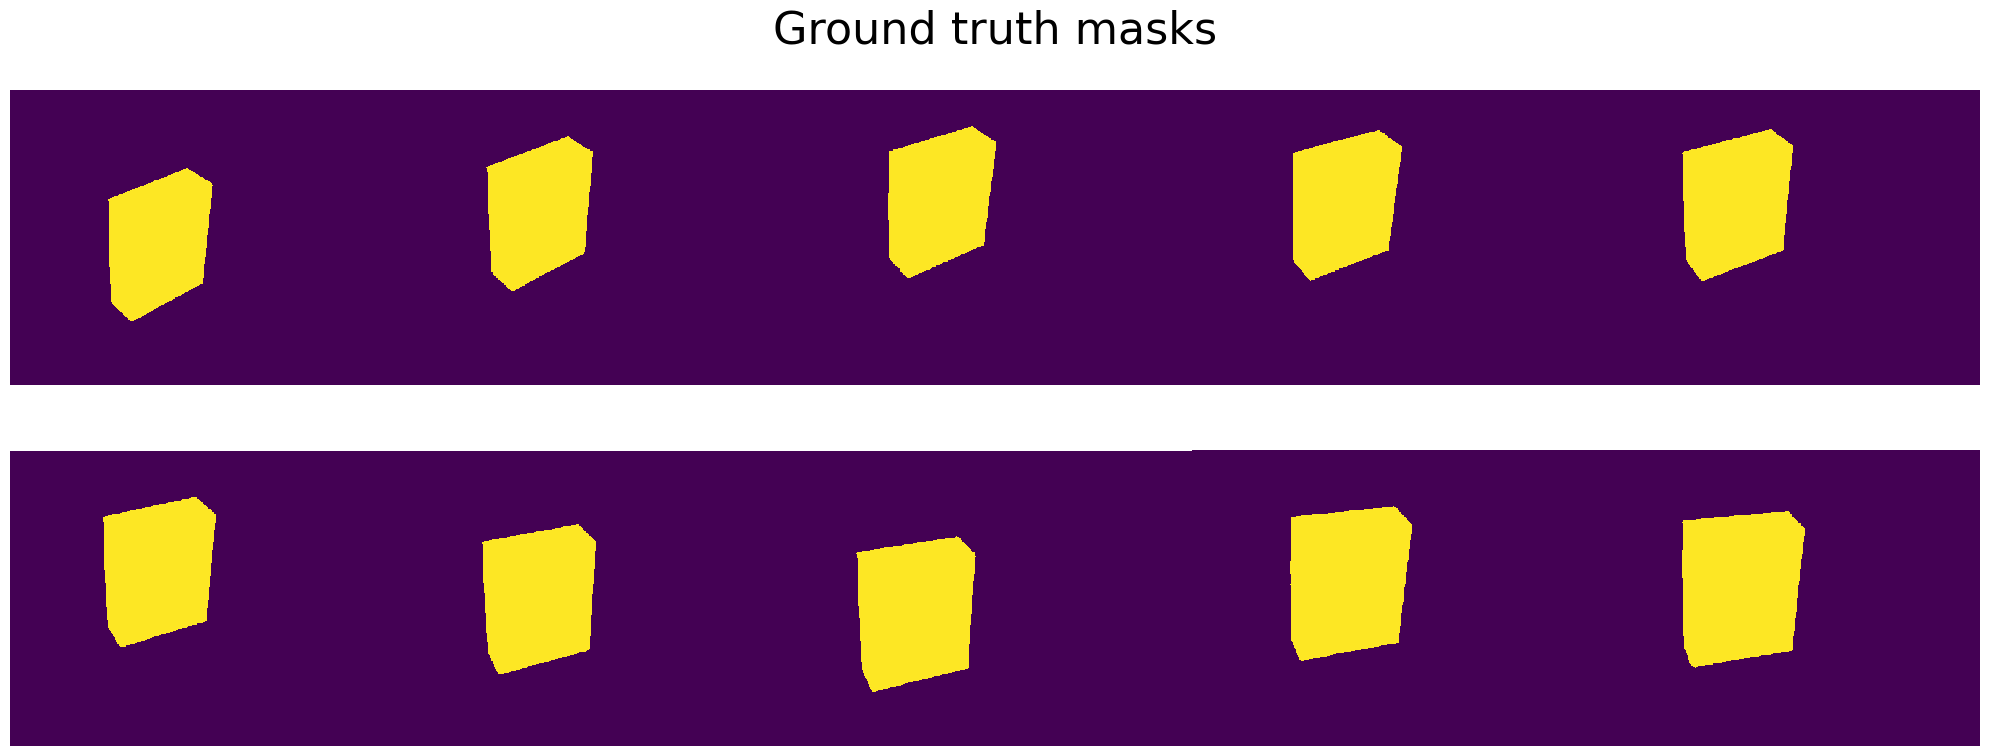

In [ ]:
## YCBV dataloading.

scene_idx = 1
N_FRAMES = 10
FRAMES = np.linspace(1, 250, N_FRAMES).astype(int)  

all_data = utils.get_ycbv_data(ycb_dir, scene_idx, FRAMES, fields=[])

ref_depths = []
target_sils = []
cam_poses = []
obj_poses = []
cameras_list = []

# scene data
object_idx = 1
fx, fy, cx, cy = all_data[0]["camera_intrinsics"]
near, far = 0.01, 4.5
height = 480
width = 640
image_size = (height, width)
mesh = utils.get_ycb_mesh(ycb_dir, all_data[0]["object_types"][object_idx])
mesh_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
_mesh_vtx = mesh.vertices  # untransformed vertices

# camera data 
intrinsics = Intrinsics(
    height=height,
    width=width,
    fx=fx,
    fy=fy,
    cx=cx,
    cy=cy,
    near=near,
    far=far,
)
K = np.array(
    [
        [intrinsics.fx, 0, intrinsics.cx],
        [0, intrinsics.fy, intrinsics.cy],
        [0, 0, 1],
    ]
)
pixel_list = (
    (np.array(np.meshgrid(np.arange(width), np.arange(height), [0]))[:, :, :, 0])
    .reshape((3, -1)).T
)
camera_rays = (pixel_list - K[:, 2]) / np.diag(K)
camera_rays[:, -1] = 1

print(f"{_mesh_vtx.shape} vertices in mesh")
print(f"{np.unique(_mesh_vtx, axis=0).shape} unique vertices in mesh")


for frame_idx, FRAME in enumerate(FRAMES):
    # poses
    _cam_pose = all_data[frame_idx]["camera_pose"]  # NOT identity but obj pose is in world frame already
    cam_pose = np.array([_cam_pose[0], _cam_pose[1], _cam_pose[2],  _cam_pose[6], _cam_pose[3], _cam_pose[4], _cam_pose[5]]) # for renderer, quat scalar should come first.
    _object_pose = all_data[frame_idx]["object_poses"][object_idx]  # pose in world frame
    object_pose = np.array([_object_pose[0], _object_pose[1], _object_pose[2],  _object_pose[6], _object_pose[3], _object_pose[4], _object_pose[5]]) # for renderer, quat scalar should come first.
    object_mask = all_data[frame_idx]["masks"][object_idx]

    # image data
    ycb_rgb = all_data[frame_idx]["rgb"]
    ycb_depth = all_data[frame_idx]["depth"]
    height, width = ycb_rgb.shape[:2]
    
    # GT viz: transform and project mesh to rgbd
    mesh_vtx_camframe = transform_points_jittable(object_pose, _mesh_vtx)  # used just for viz
    mesh_vtx_worldframe = transform_points_by_inv_jittable(cam_pose, mesh_vtx_camframe)
        
    ## store cam info
    obj_poses.append(object_pose)
    cam_poses.append(cam_pose)
    xfm_rays = transform_rays(camera_rays, cam_pose[3:], cam_pose[:3])
    cameras_list.append(xfm_rays)

    x = np.array(fy * mesh_vtx_camframe[:, 1] / mesh_vtx_camframe[:, 2] + cy, dtype=np.int32)
    y = np.array(fx * mesh_vtx_camframe[:, 0] / mesh_vtx_camframe[:, 2] + cx, dtype=np.int32)
    pixels = np.stack([x, y], axis=1)
    # clip to bounds
    pixels = np.clip(pixels, 0, np.array([height - 1, width - 1]))
    rgb = np.zeros((height, width, 3), dtype=np.uint8)
    depth = np.zeros((height, width, 1))

    rgb[pixels[:, 0], pixels[:, 1], :] = mesh_colors * 255
    depth[pixels[:, 0], pixels[:, 1], 0] = mesh_vtx_camframe[:, 2]
    
    # smooth the depth projection to a silhouette mask
    kernel = np.ones((5, 5), np.uint8)
    depth_mask = depth # np.where(depth > 0, 1, 0).astype(np.uint8)
    solid_depth = cv2.dilate(depth_mask, kernel, iterations=3)
    solid_depth = cv2.erode(solid_depth, kernel, iterations=3)
    solid_depth = cv2.morphologyEx(solid_depth, cv2.MORPH_CLOSE, kernel)
    sil = np.where(solid_depth, 1, 0).astype(np.float32)
    
    target_sils.append(sil)
    ref_depths.append(solid_depth.astype(np.float32))   
    
    ##
    # viz data
    ##
    if False:
        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        axes[0].imshow(ycb_rgb)
        axes[1].imshow(sil)
        axes[2].imshow(depth)
        axes[3].imshow(solid_depth)    

        plt.show()

image_grid(target_sils, rows=2, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Ground truth masks', fontsize=32)

# Optimize from a random cloud to a shape

In [8]:
import baseline.fm_render as fm_render
from baseline.util_render import quat_to_rot

jax_render = fm_render.render_func_rays
jax_render_jit = jax.jit(fm_render.render_func_rays)

In [ ]:
## Hyperparameters

id_pose = np.array([0, 0, 0, 1, 0, 0, 0])
shape_scale = 1.0
opt_shape_scale = 2.2
shape_scale_mul = opt_shape_scale/shape_scale

beta2 = 21.4  # from the fuzzy metaballs paper
beta3 = 2.66

In [10]:
NUM_MIXTURE = 60
rng = np.random.default_rng(123)
center = _mesh_vtx[rng.integers(0, len(_mesh_vtx), NUM_MIXTURE)]

gmm_init_scale = 80
rand_mean = center + np.random.multivariate_normal(mean=[0,0,0],cov=5e-4*np.identity(3),size=NUM_MIXTURE)
rand_quats = np.array(
    [[1,0,0,0] for _ in range(NUM_MIXTURE)], dtype=np.float32
)  # identity rotation
rand_scales = np.array([[1 / jnp.sqrt(5e3), 1 / jnp.sqrt(5e3), 1 / jnp.sqrt(5e3)] for _ in range(NUM_MIXTURE)])
rand_weight_log = jnp.log(np.ones(NUM_MIXTURE)/NUM_MIXTURE) + jnp.log(gmm_init_scale)

Text(0.5, 0.98, 'Initial Masks')

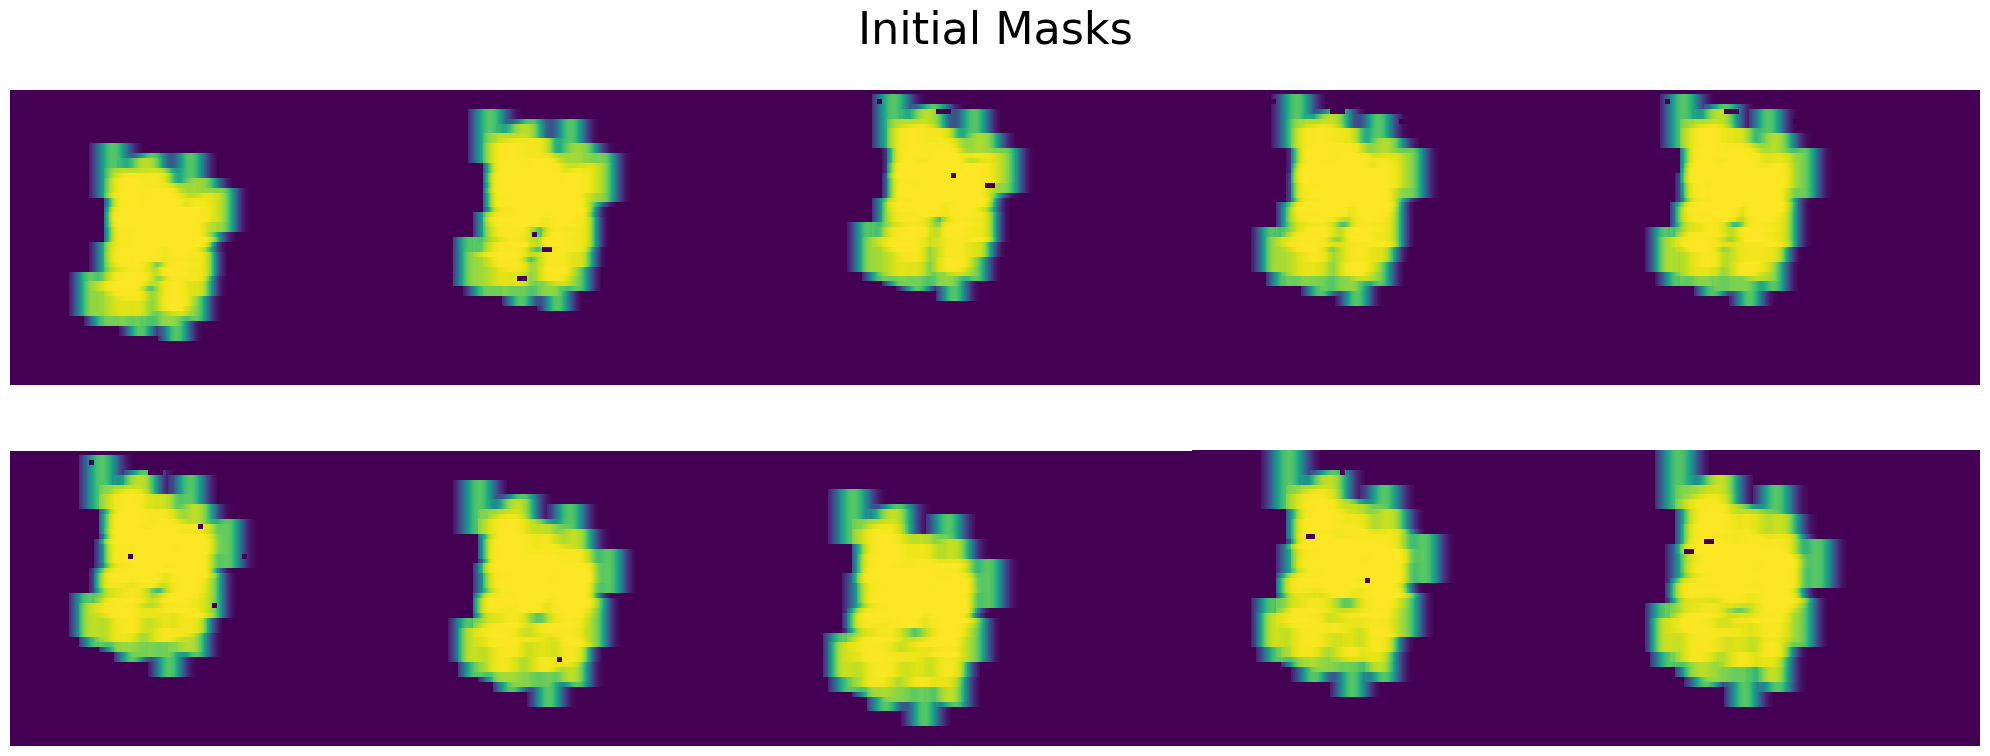

In [11]:
## visualize initial for a few cam frames
init_results_alpha = []
init_results_depth = []
for obj_pose in obj_poses:
    init_depth, init_alpha = fuzzy_rasterize_jit(transform_points_jittable(obj_pose, rand_mean), 
                                                 rand_scales, rand_quats, rand_weight_log,
                                                camera_rays, quat_to_rot(id_pose[3:]), id_pose[:3], 
                                                image_size[0], image_size[1], 
                                                fx, fy, cx, cy, near, far)

    init_results_alpha.append(init_alpha.reshape(image_size))
    
    init_depth = np.array(init_depth)
    # init_depth[init_alpha < 0.5] = np.nan
    init_results_depth.append(init_depth.reshape(image_size))

image_grid(init_results_alpha, rows=2, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Initial Masks', fontsize=32)


In [12]:
# vmin = np.nanmin(np.array(ref_depths))
# vmax = np.nanmax(np.array(ref_depths))
# plt.imshow(init_results_depth[0],vmin=vmin,vmax=vmax)
# plt.colorbar()
# plt.show()

In [13]:
def prec_from_rotscale(rotations, scales):
    _rot_mtx = jnp.array([quat_to_rot(q) for q in rotations])
    _scale_mtx = jnp.array([jnp.diag(s) for s in scales])
    _rs = jnp.einsum(
        "aij,ajk->aik", _rot_mtx, _scale_mtx
    ) 
    _cov = jnp.einsum("aij,ajk->aik", _rs, _rs.transpose(0, 2, 1))
    prec = jnp.linalg.cholesky(jnp.linalg.inv(_cov)) 
    return prec
prec_from_rotscale_jit = jax.jit(prec_from_rotscale)

def jax_objective(params,true_alpha):
    CLIP_ALPHA = 3e-8
    _means, scales, rotations, weights_log, camera_rays_xfm, obj_pose, cam_pose = params
    _mean_camspace = transform_points_jittable(obj_pose, _means)
    means = transform_points_by_inv_jittable(cam_pose, _mean_camspace)

    # update backward pass variables
    prec = prec_from_rotscale_jit(rotations, scales)
        
    render_res = jax_render_jit(camera_rays_xfm, means,prec,weights_log,beta2,beta3)

    est_alpha = render_res[1].reshape(true_alpha.shape)
    est_alpha = jnp.clip(est_alpha,CLIP_ALPHA,1-CLIP_ALPHA)
    mask_loss = - ((true_alpha * jnp.log(est_alpha)) + (1-true_alpha)*jnp.log(1-est_alpha))
        
    return mask_loss.mean(), est_alpha


def objective(params,true_alpha):
    CLIP_ALPHA = 3e-8
    # means,prec,weights_log,camera_rays,beta2,beta3 = params
    means, scales, rotations, weights_log, camera_rays_unxfm, cam_pose = params
    render_res = fuzzy_rasterize(means,scales, rotations,weights_log,
                                     camera_rays_unxfm, quat_to_rot(cam_pose[3:]), cam_pose[:3], 
                                     image_size[0], image_size[1],
                                     fx, fy, cx, cy, near, far)

    est_alpha = render_res[1]
    est_alpha = jnp.clip(est_alpha,CLIP_ALPHA,1-CLIP_ALPHA)
    mask_loss = - ((true_alpha * jnp.log(est_alpha)) + (1-true_alpha)*jnp.log(1-est_alpha))
    return mask_loss.mean(), est_alpha

optim_fwd = objective #jax.jit(objective)
optim_bwd = jax.jit(jax.grad(jax_objective, has_aux=True))

In [ ]:
LOAD_FROM_NPZ = True 

# load previous gradient descent results
if LOAD_FROM_NPZ:
    data = np.load("checkpoint_data_1209.npz")  # or any npz name previously saved
    final_mean = data['final_mean']
    final_scale = data['final_scale']
    final_rot = data['final_rot']
    final_weight_log = data['final_weight_log']
    loss = data['loss']
    losses = data['losses']
     
# rerun gradient descent   
else:
    from jax.example_libraries import optimizers
    def irc(x): return int(round(x))

    # Number of optimization steps
    Nepochs = 3
    Niter_epoch = N_FRAMES

    vecM = jnp.array([[1,1,1],[shape_scale_mul,shape_scale_mul,shape_scale_mul]])[None]

    outer_loop = tqdm(range(Nepochs), desc=" epoch", position=0)

    adjust_lr = DegradeLR(1e-3,0.5,irc(Niter_epoch*0.4),irc(Niter_epoch*0.1),-1e-4)
    opt_init, opt_update, opt_params = optimizers.adam(adjust_lr.step_func)
    opt_update = jax.jit(opt_update)
    # tmp = [rand_mean*shape_scale_mul,rand_prec/shape_scale_mul,rand_weight_log]

    tmp = [rand_mean, rand_scales, rand_quats, rand_weight_log]
    opt_state = opt_init(tmp)


    rand_idx = np.arange(N_FRAMES)

    losses = []
    done = False
    ckpt = None
    prev_loss = np.inf


    for i in outer_loop:
        for img_idx in tqdm(range(Niter_epoch), desc=" iteration", position=1, leave=False):
            p = opt_params(opt_state)
            _mean, _scale, _rot, _weight = p
            # print(_mean.shape, _scale.shape, _rot.shape, _weight.shape)
            # print(_mean.dtype, _scale.dtype, _rot.dtype, _weight.dtype)
            _mean_camspace = transform_points_jittable(obj_poses[img_idx], _mean)

            val, debug1 = optim_fwd([_mean_camspace, _scale, _rot, _weight, camera_rays, id_pose], target_sils[img_idx])   
            g, debug = optim_bwd([_mean, _scale, _rot, _weight, cameras_list[img_idx], obj_poses[img_idx], cam_poses[img_idx]], target_sils[img_idx])
            opt_state = opt_update(i, g[:4], opt_state)

            loss_val = float(val)
            losses.append(loss_val)
            outer_loop.set_description("total_loss = %.3f" % loss_val)
            
            if loss_val < prev_loss:
                prev_loss = loss_val
                ckpt = (opt_params(opt_state), loss_val)
            
            if adjust_lr.add(val):
                done = True
                break
        if done:
            break

    if ckpt is not None:
        (final_mean, final_scale, final_rot, final_weight_log), loss = ckpt
        print(loss)
    else:
        (final_mean, final_scale, final_rot, final_weight_log) = opt_params(opt_state)    
        
    np.savez(f"checkpoint_data_{NUM_MIXTURE}g_{Nepochs}ep_{Niter_epoch}it_{N_FRAMES}frames.npz", 
         final_mean=final_mean, 
         final_scale=final_scale, 
         final_rot=final_rot, 
         final_weight_log=final_weight_log, 
         loss=loss,
         losses=losses)

Text(0, 0.5, 'log loss')

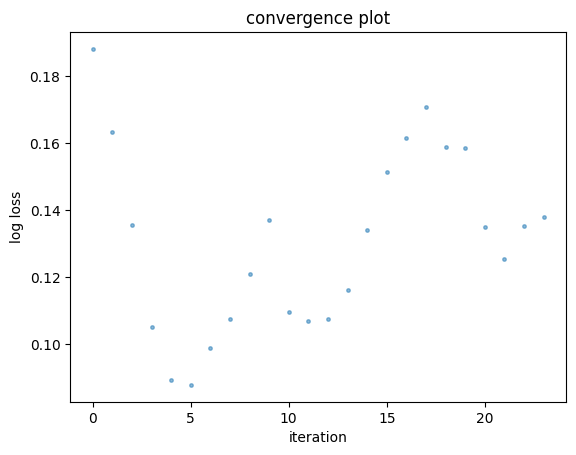

In [15]:
plt.title('convergence plot')
plt.plot(losses,marker='.',lw=0,ms=5,alpha=0.5)
plt.xlabel('iteration')
plt.ylabel('log loss')

# Visualize Results

Text(0.5, 0.98, 'Final Masks')

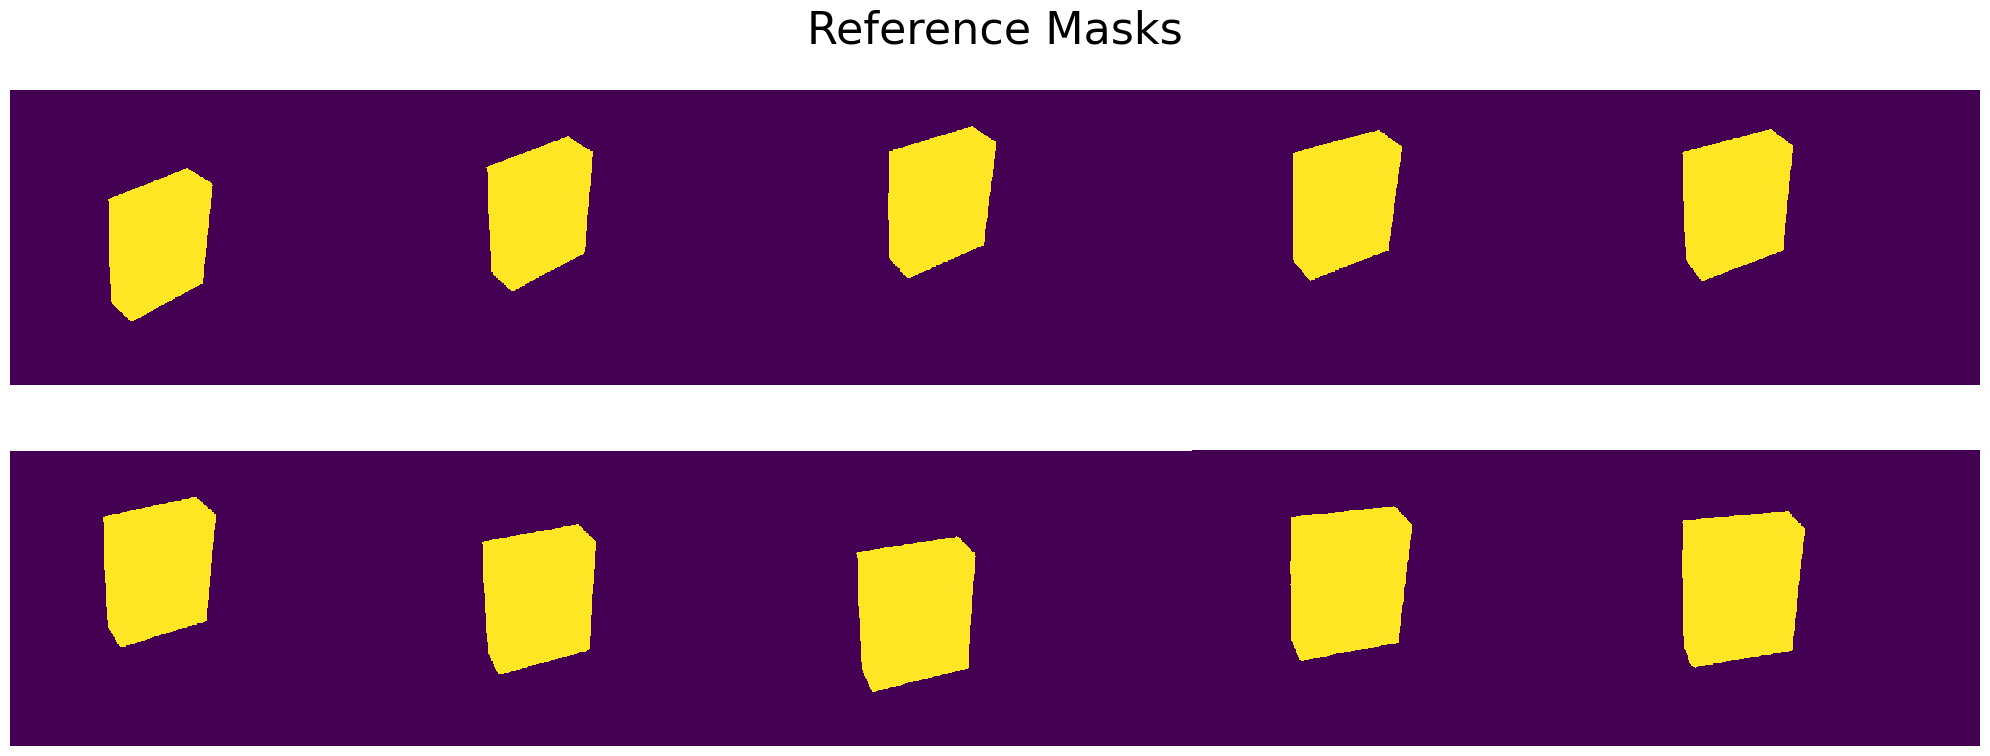

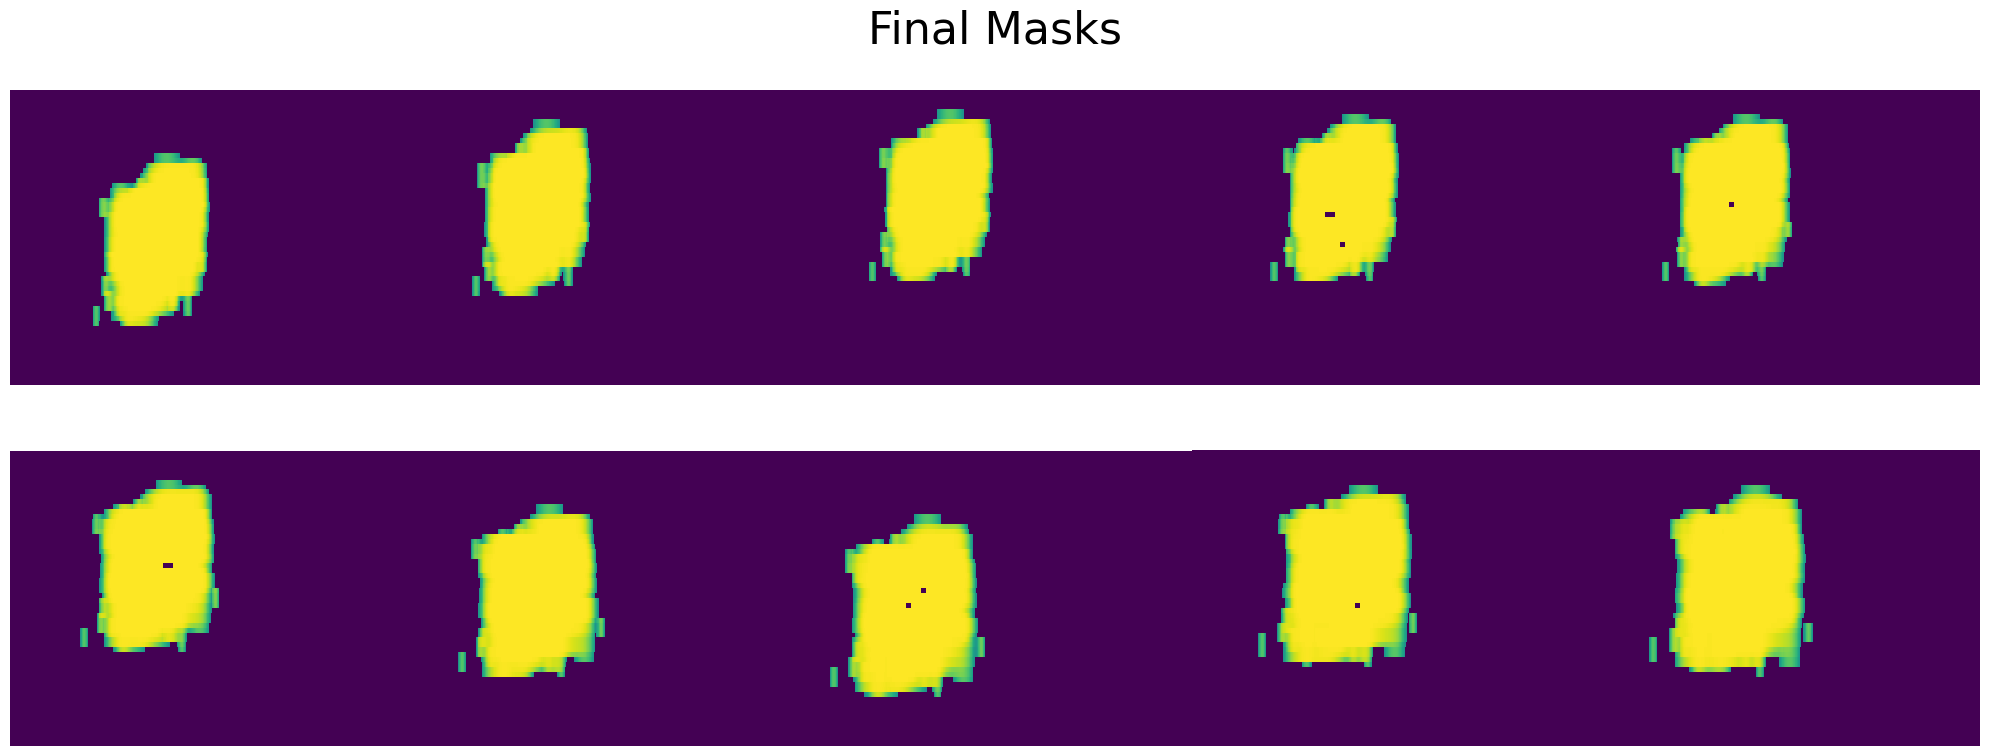

In [16]:
alpha_results_final = []
alpha_results_depth = []
ALPHA_THRESH = 0.5
for obj_pose in obj_poses:
    est_depth, est_alpha = fuzzy_rasterize_jit(transform_points_jittable(obj_pose, final_mean), 
                                            final_scale, final_rot, final_weight_log,
                                            camera_rays, quat_to_rot(id_pose[3:]), id_pose[:3],
                                            image_size[0], image_size[1], 
                                            fx, fy, cx, cy, near, far)
    
    est_alpha = np.where(est_alpha > ALPHA_THRESH, est_alpha, 0)
    est_depth = np.array(est_depth)
    
    est_depth[est_alpha < ALPHA_THRESH] = np.nan
    alpha_results_depth.append(est_depth.reshape(image_size))
    alpha_results_final.append(est_alpha.reshape(image_size))

image_grid(target_sils, rows=2, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Reference Masks', fontsize=32)
 
image_grid(alpha_results_final, rows=2, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Final Masks', fontsize=32)

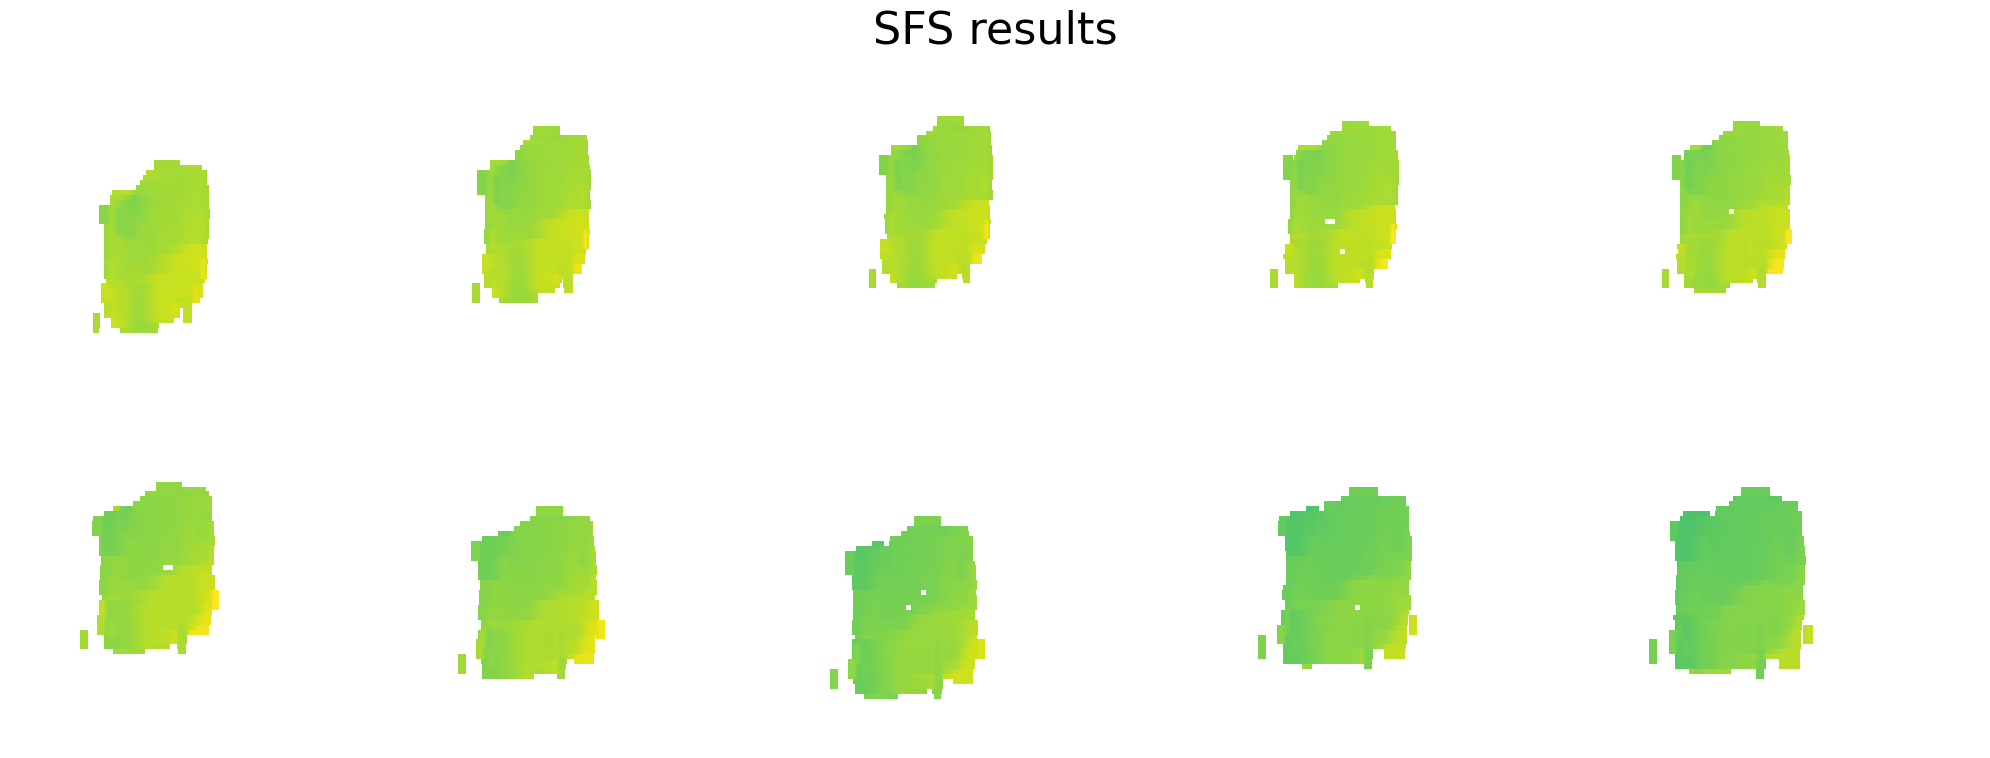

In [25]:
vmin = np.nanmin(np.array(ref_depths))
vmax = np.nanmax(np.array(ref_depths))
image_grid(alpha_results_depth, rows=2, cols=5, rgb=False,vmin=vmin,vmax=vmax)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('SFS results', fontsize=32)
plt.tight_layout()

In [18]:
# 